In [7]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

# ###
# import linearfitting as linfit
import lmcgeometry as lgeo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Gradients_with_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC r13 data
lmc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

In [9]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

In [55]:
#####################
### MLE Functions ###
#####################

from scipy.optimize import minimize
from scipy.stats import binned_statistic

def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    ----------
        dat: array-like object containing data
    
    Returns:
    -------
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

def linmodl(m,b,x):
    '''
    Slope-intercept form of a line
    
    Parameters:
    ----------
        m: slope of line
        x: exog of line
        b: intercept of line
        
    Returns:
    -------
        y: endog of line
    '''
    y = m*x + b
    return y

def lnL(theta,x,y,yerr):
    '''
    Log likelihood for linmodl
    
    Parameters:
    ----------
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        yerr: endog error
    
    Returns:
    -------
        lnl: log likelihood 
    '''
    
    m, b = theta #, msig, bsig = theta
    modl = linmodl(m,b,x)
    #sigmodl = linmodl(msig,bsig,x)
    inv_sig2 = np.reciprocal(np.square(yerr))#+np.square(sigmodl))
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

# def mle_fit(exog,endog,endog_err):
#     '''
#     Do a MLE fit of median abundances as function (y = mx + b) of radius
#     using unbinned data
    
#     Parameters:
#     ----------
#         exog: radii for stars
#         endog: abundances for stars
#         endog_err: errors in abund
#     Returns:
#     -------
#         med_m: slope of line fit
#         med_b: intercept of line fit
#     '''
    
#     #Calculate bins
#     bins = np.arange(np.floor(np.min(exog)),np.ceil(np.max(exog)),1.0) 
    
#     #Calcuradius[cln]late median value for each bin
#     bin_stats, _, _ = binned_statistic(exog,endog,statistic='median',bins=bins)
    
#     #Calculate spread (MAD) in values in each bin
#     bin_stats_err, _, _ = binned_statistic(exog,endog,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
#                                            bins=bins)
    
#     #Initialize MLE calculation
#     med_exog = np.arange(len(bin_stats))+0.5
#     med_endog = bin_stats
#     med_endog_err = bin_stats_err
    
#     med_m_guess = (bin_stats[1]-bin_stats[0])/(med_exog[1]-med_exog[0])
#     med_b_guess = bin_stats[0]
    
#     # minimize MLE and find slopes and intercepts
#     nll = lambda *args: -lnL(*args)
#     med_guess = np.array([med_m_guess, med_b_guess])
#     med_soln = minimize(nll, med_guess, args=(med_exog, med_endog, med_endog_err))
#     med_m_ml, med_b_ml = med_soln.x
    
#     return med_m_ml, med_b_ml

In [164]:
######################
### MCMC Functions ###
######################

def lnPrior(theta):
    m, b = theta #, msig, bsig = theta
    if -1.0 < m < 1.0 and -2.0 < b < 2.0: #and -1.0 < msig < 1.0 and -4.0 < bsig < 4.0:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y, yerr)

In [57]:
# med_ms = []
# med_bs = []

# ### Initial fit
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     # clean up data
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    
#     # fit data
#     slope, inter = mle.mle_fit(radius[cln],r13[elems[i]][cln],r13[elems_err[i]][cln])
#     med_ms.append(slope)
#     med_bs.append(inter)

In [178]:
############
### MCMC ###
############

import emcee
import time

i = 0
cln = np.where((lmc[elems[i]]>-100.)&(lmc['SNR']>=100))

rad_cln = radius[cln]
elem_cln = lmc[elems[i]][cln]
elem_cln_err = lmc[elems[i]+'_ERR'][cln]

### Initial Guess
bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
bin_stats, _, _ = binned_statistic(rad_cln,elem_cln,statistic='median',bins=bins)
# bin_stats_err, _, _ = binned_statistic(rad_cln,elem_cln,
#                                        statistic=lambda y: np.median(np.absolute(y-np.median(y))),bins=bins)

bin_x = np.arange(len(bin_stats))+0.5
m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
b_guess = bin_stats[0]
#msig_guess = (bin_stats_err[1]-bin_stats_err[0])/(bin_x[1]-bin_x[0])
#bsig_guess = bin_stats_err[0]
guess = [m_guess,b_guess]#,msig_guess,bsig_guess]

nll = lambda *args: -lnL(*args)
result = minimize(nll, guess, args=(rad_cln, elem_cln, elem_err_cln))

if not np.isfinite(lnProb(guess,rad_cln,elem_cln,elem_cln_err)):
    guess = result.x
else:
    print('Bad Guess')
    print(guess)

niter = 1000
ndim, nwalkers = 2,500 
pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=(rad_cln, elem_cln, elem_err_cln))
pos, prob, state = sampler.run_mcmc(pos, 5000, progress=True)
sampler.reset()
    
# sampler.run_mcmc(pos, niter)
printStep = int(niter/2)
last = time.time()
for i, res in enumerate(sampler.sample(pos, iterations=niter)):
    if (i+1) % printStep ==0:
        now = time.time()
        print("{:s} {:5.1%} {:5.1f}".format("mcmc", float(i) / niter, int(now-last)))
        last = time.time()

frac = sampler.acceptance_fraction

accepted = frac[np.array(frac) > 0.25]

print(len(accepted), len(frac))

  0%|          | 0/5000 [00:00<?, ?it/s]

Bad Guess
[-0.007299959659576416, -0.6433615684509277]


100%|██████████| 5000/5000 [03:16<00:00, 25.50it/s]


mcmc 49.9%  15.0
mcmc 99.9%  14.0
500 500


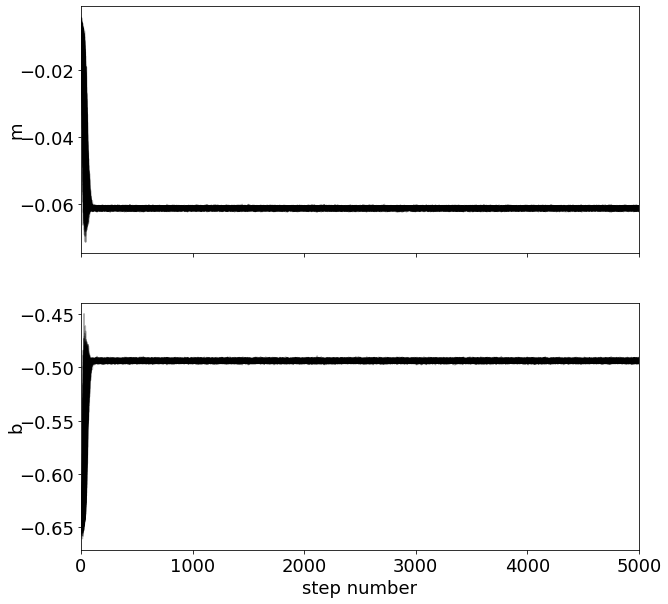

In [173]:
fig, axes = plt.subplots(2, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]#, r"m$_\sigma$",r"b$_\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [174]:
tau = sampler.get_autocorr_time()
print(tau)

[44.65852202 46.6264936 ]


In [175]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
# print(flat_samples.shape)

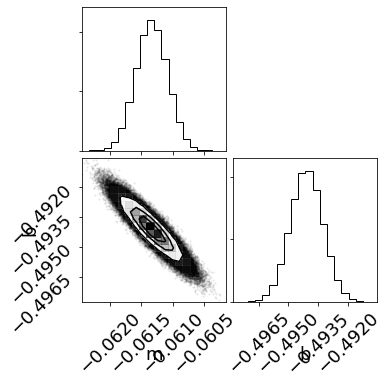

In [176]:
import corner
corner.corner(flat_samples, labels=labels);

In [179]:
print('slope:',np.median(flat_samples[:,0]))
print('slope uncert:',mad(flat_samples[:,0]))
print('inter:',np.median(flat_samples[:,1]))
print('inter uncert:',mad(flat_samples[:,1]))

slope: -0.06134029508035256
slope uncert: 0.00016949665728271598
inter: -0.494096837290854
inter uncert: 0.0005556211082704265
